# Google Stock Time Series
# Irzan Fajari Nurahmadan

# Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import Dataset

In [ ]:
df = pd.read_csv('/content/drive/My Drive/dataset/GOOGL.csv', index_col='Date', parse_dates=['Date'])

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


# Data Preprocessing

In [ ]:
df = df.drop(['Open','Low','Close','Volume','Name'],axis=1)

# Split Data

In [ ]:
Train, Test = train_test_split(df, test_size=0.2, shuffle = False)

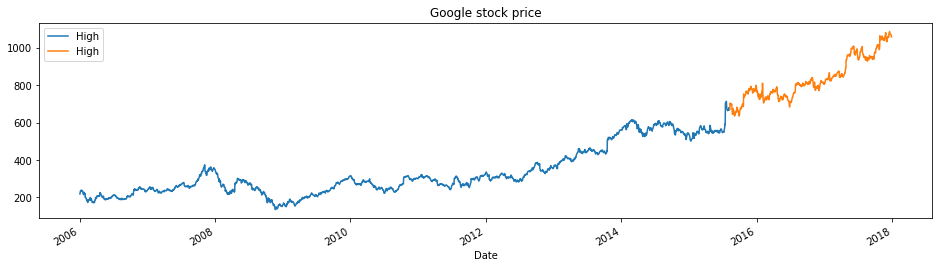

In [ ]:
Train["High"].plot(figsize=(16,4),legend=True)
Test["High"].plot(figsize=(16,4),legend=True)
plt.title('Google stock price')
plt.show()

# Data Normalization Using MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(Train)

In [ ]:
training_set_scaled.shape

(2415, 1)

# Creating Time Series Dataset

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2415):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
test_set_scaled = sc.transform(Test)

In [ ]:
test_set_scaled.shape

(604, 1)

In [ ]:
X_test = []
y_test = []
for i in range(60,604):
    X_test.append(test_set_scaled[i-60:i,0])
    y_test.append(training_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Make LSTM Based Model

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=60, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Callback To Control Training

In [ ]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, mode='min')

# Training The LSTM Model

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.6)
regressor.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = regressor.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=100, batch_size=20,callbacks=Callback)

Epoch 1/100
118/118 [==============================] - 12s 57ms/step - loss: 0.0795 - mae: 0.3281 - val_loss: 0.0145 - val_mae: 0.1524
Epoch 2/100
118/118 [==============================] - 6s 48ms/step - loss: 0.0650 - mae: 0.2834 - val_loss: 0.0084 - val_mae: 0.1046
Epoch 3/100
118/118 [==============================] - 6s 48ms/step - loss: 0.0545 - mae: 0.2483 - val_loss: 0.0051 - val_mae: 0.0755
Epoch 4/100
118/118 [==============================] - 6s 47ms/step - loss: 0.0467 - mae: 0.2215 - val_loss: 0.0037 - val_mae: 0.0637
Epoch 5/100
118/118 [==============================] - 6s 48ms/step - loss: 0.0409 - mae: 0.2021 - val_loss: 0.0036 - val_mae: 0.0672
Epoch 6/100
118/118 [==============================] - 6s 48ms/step - loss: 0.0367 - mae: 0.1885 - val_loss: 0.0043 - val_mae: 0.0784


# Plotting Train History of LSTM Model

In [ ]:
def graph(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('mae')
    ax[1].plot(history.epoch, history.history["mae"], label="Train mae")
    ax[1].plot(history.epoch, history.history["val_mae"], label="Validation mae")
    ax[0].legend()
    ax[1].legend()

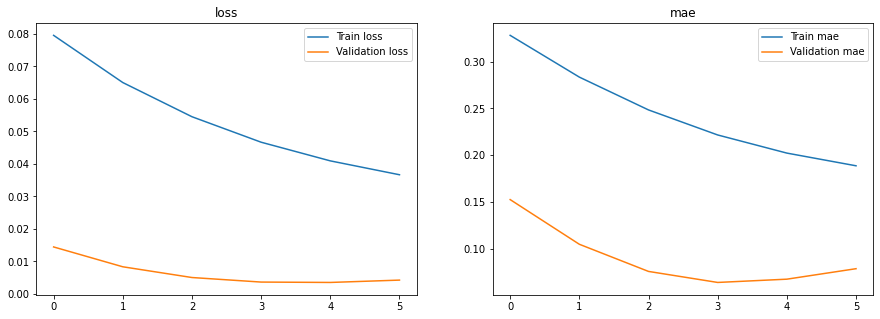

In [ ]:
graph(history)